In [51]:
import torch
#import numpy as np
#import torch.nn as nn
#import torch.optim as optim
#import torch.nn.functional as F
#import matplotlib.pyplot as plt
#import torch.utils.data as tud



from func4skipgram import Vocab, wash_chinese, change_None
import pickle
import os

# 导入模型定义
from skipgram_model import EmbeddingModel
    
source = 'pinyin'

# 读取词典
with open('skipgram_corpus/' + source + '.bin', 'rb') as f:
    voca = pickle.load(f)
print('voca读取成功')
# 创建并读取模型
model = EmbeddingModel(len(voca), 25)  # 创建skip gram model
model.load_state_dict(torch.load(f'models/skipgram_{source}.pth'))
model.eval()

# print(model.in_embed(torch.IntTensor([1, 3])))


voca读取成功
tensor([[ 0.0658, -0.0517, -0.2832,  0.1990,  0.4710, -0.1424, -0.1084,  0.2110,
         -0.2954,  0.0695,  0.2482, -0.0725, -0.3346,  0.0811,  0.4007,  0.0873,
         -0.1557,  0.2638,  0.1518,  0.1409,  0.1927,  0.2028,  0.1418,  0.1817,
          0.0916],
        [-0.0309,  0.8294,  0.3473,  0.0379, -0.3182, -0.4953, -0.2454,  0.4245,
         -0.4190, -0.6181,  0.1619,  0.0172, -0.3263, -0.4006,  0.1892, -0.7813,
         -0.2028, -0.4336,  0.0671,  0.4441, -1.3459, -0.2262,  0.0240, -0.4498,
         -0.2773]], grad_fn=<EmbeddingBackward0>)


In [48]:
# 三，直接输入词，查看这些单个的字模型给出的语境词预测

testwords = ['机器3学习', '中间可-/%以x做', '丝氨酸蛋白酶'] # 在这里以列表存单个字或词或句的方式放你想测试的token

from cnradical import Radical, RunOption
radical = Radical(RunOption.Radical)
pinyin = Radical(RunOption.Pinyin)

res = wash_chinese(testwords)
res = [change_None(pinyin.trans_ch, ele) for ele in res]

preres = {} # 概率最大
for token in res: # 取出中间可以做预测的词
    center = token
    ids = voca[center] # 取出来的是一个数字
    ids = torch.IntTensor([ids])  # 得到预测
    pre = model(ids)
    
    argm = torch.topk(pre, K, dim=1, largest=True, sorted=True, out=None) # -> (Tensor, LongTensor)
    #print(argm)
    prop = argm[0]
    words = voca.to_tokens(list(argm[1][0]))
    #print(words)
    #print(context)
    for word in context:
        if word in words: 
            correct += 1
    preres[center] = words


print(*list(preres.items()), sep='\n')

('jī', ['jī', 'kōng', 'hōng', 'dí', 'zhàn', 'gòu', 'jiàn', 'páo', 'gōng', 'zhà'])
('qì', ['qì', 'wēn', 'kōng', 'chòu', 'rǎn', 'dí', 'suān', 'huǎn', 'nuǎn', 'hōng'])
('<unk>', ['<unk>', 'nián', 'yuè', 'rì', 'wàn', 'mǐ', 'yuē', 'yú', 'yuán', 'zhì'])
('xué', ['xué', 'yuàn', 'xiào', 'kē', 'zhé', 'jiū', 'dà', 'jiào', 'wén', 'zhōng'])
('xí', ['xuǎn', 'zhǔ', 'wěi', 'rèn', 'xí', 'xué', 'huì', 'dǎng', 'guó', 'yuàn'])
('zhōng', ['guó', 'yāng', 'huá', 'xué', 'zhōng', 'gòng', 'mín', 'dà', 'dí', 'dǎng'])
('jiān', ['shí', 'jiān', 'qī', 'dí', 'zhī', 'zài', 'kōng', 'cháng', 'yǒu', 'bù'])
('kě', ['kě', 'néng', 'yǐ', 'yòng', 'guò', 'dí', 'zhè', 'bù', 'qiě', 'xū'])
('yǐ', ['kě', 'yòng', 'yǐ', 'shì', 'tā', 'liáng', 'yǒu', 'néng', 'bù', 'shù'])
('zuò', ['pǐn', 'dí', 'wéi', 'zuò', 'yòng', 'gōng', 'yào', 'shì', 'yǒu', 'zhè'])
('sī', ['sī', 'tǎn', 'qiǎ', 'kè', 'ní', 'ěr', 'tè', 'ā', 'luó', 'mài'])
('ān', ['ān', 'xī', 'shān', 'ní', 'lín', 'zhōu', 'dōng', 'jùn', 'yà', 'běi'])
('suān', ['ǎn', 'suān', 'chòu', 'sò

In [44]:
# 评价方法一
C = 4
testsentence = ['机器学习是一门多领域交叉学科，涉及概率论、统计学、逼近论、凸分析、算法复杂度理论等多门学科。专门研究计算机怎样模拟或实现人类的学习行为，以获取新的知识或技能',
                '刘少奇（1898年11月24日-1969年11月12日），生于湖南省宁乡县，伟大的马克思主义者'

]
K = 4
for s in testsentence:
    res = wash_chinese(s)
    pre1 = [[i]*K for i in list(res[:C])] # 概率最大
    likelihood = [0]*C # 可能性
    correct = 0
    for i in range(len(res) - 2*C-1): # 取出中间可以做预测的词
        context = res[i: i+C] + res[i+C+1:i+2*C+1]
        center = res[i+3]
        ids = voca[context]
        ids = torch.IntTensor(ids)  # 只要输入的是列表就没有问题
        pre = model(ids)
        pre = pre.log().sum(dim=0) # 对数和 
        topkpre = torch.topk(pre, K, dim=0, largest=True, sorted=True) # -> (Tensor, LongTensor)
        prop = topkpre[0]
        words = voca.to_tokens(list(topkpre[1]))
        
        #print(words)
        #input()
        if center in words: correct += 1
        pre1.append(words)
        likelihood.append(float(prop.mean(dim=0)))
    print(''.join(res))
    #print(''.join(pre1))
    for i in range(K):
        print(''.join([item[i] for item in pre1]))

    print(f'正确率{correct/(len(res)-2*C):3f}')
    print(f'平均likelihood={sum(likelihood)/len(likelihood):3f}')
    print('\n')




机器学习是一门多领域交叉学科涉及概率论统计学逼近论凸分析算法复杂度理论等多门学科专门研究计算机怎样模拟或实现人类的学习行为以获取新的知识或技能
机器学习<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>
机器学习niánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánniánnián
机器学习yuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuèyuè
机器学习rìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrìrì
正确率0.000000
平均likelihood=-31.740771


刘少

In [45]:
# 评价方法二，找出预测概率最高的几个词，判断8个窗口词是否被包含在内
C = 4
testsentence = ['机器学习是一门多领域交叉学科，涉及概率论、统计学、逼近论、凸分析、算法复杂度理论等多门学科。专门研究计算机怎样模拟或实现人类的学习行为，以获取新的知识或技能',
                '刘少奇（1898年11月24日-1969年11月12日），生于湖南省宁乡县，伟大的马克思主义者'

]
K = 10
# torch.topk(input, k, dim=None, largest=True, sorted=True, out=None) -> (Tensor, LongTensor)
#input:tensor数据
#k:排序后的前k个数据
#dim:沿着某个维度
#largest：True是指从大到小，否则，从小到大
#sorted:True返回的结果


for s in testsentence[:1]:
    res = wash_chinese(s)
    preres = {} # 概率最大
    likelihood = [] # 可能性
    correct = 0
    for i in range(len(res) - 2*C-1): # 取出中间可以做预测的词
        context = res[i: i+C] + res[i+C+1:i+2*C+1]
        center = [res[i+C]]
        ids = voca[center] # 取出来的是一个数字
        ids = torch.IntTensor(ids)  # 得到预测
        pre = model(ids)
        
        argm = torch.topk(pre, K, dim=1, largest=True, sorted=True, out=None) # -> (Tensor, LongTensor)
        #print(argm)
        prop = argm[0]
        words = voca.to_tokens(list(argm[1][0]))
        #print(words)
        #print(context)
        for word in context:
            if word in words: 
                correct += 1
        preres[center[0]] = words
        likelihood.append(prop)

    print(f'正确率{correct/((len(res)-2*C)*2*C):3f}')
    #print(f'平均likelihood={sum(likelihood)/len(likelihood):3f}')
    print('\n')
    print(*list(preres.items()), sep='\n')

正确率0.000000


('是', ['<unk>', 'nián', 'yuè', 'rì', 'wàn', 'mǐ', 'yuē', 'yú', 'yuán', 'zhì'])
('一', ['<unk>', 'nián', 'yuè', 'rì', 'wàn', 'mǐ', 'yuē', 'yú', 'yuán', 'zhì'])
('门', ['<unk>', 'nián', 'yuè', 'rì', 'wàn', 'mǐ', 'yuē', 'yú', 'yuán', 'zhì'])
('多', ['<unk>', 'nián', 'yuè', 'rì', 'wàn', 'mǐ', 'yuē', 'yú', 'yuán', 'zhì'])
('领', ['<unk>', 'nián', 'yuè', 'rì', 'wàn', 'mǐ', 'yuē', 'yú', 'yuán', 'zhì'])
('域', ['<unk>', 'nián', 'yuè', 'rì', 'wàn', 'mǐ', 'yuē', 'yú', 'yuán', 'zhì'])
('交', ['<unk>', 'nián', 'yuè', 'rì', 'wàn', 'mǐ', 'yuē', 'yú', 'yuán', 'zhì'])
('叉', ['<unk>', 'nián', 'yuè', 'rì', 'wàn', 'mǐ', 'yuē', 'yú', 'yuán', 'zhì'])
('学', ['<unk>', 'nián', 'yuè', 'rì', 'wàn', 'mǐ', 'yuē', 'yú', 'yuán', 'zhì'])
('科', ['<unk>', 'nián', 'yuè', 'rì', 'wàn', 'mǐ', 'yuē', 'yú', 'yuán', 'zhì'])
('涉', ['<unk>', 'nián', 'yuè', 'rì', 'wàn', 'mǐ', 'yuē', 'yú', 'yuán', 'zhì'])
('及', ['<unk>', 'nián', 'yuè', 'rì', 'wàn', 'mǐ', 'yuē', 'yú', 'yuán', 'zhì'])
('概', ['<unk>', 'nián', 'yuè', 'rì', '

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 28, 29, 30, 31, 32, 33, 34, 35]
[26.381948297674004, 26.380108746615324, 26.549691460349344, 26.155991649627687, 26.444425756281074, 26.339628219604492, 26.48200104453347, 26.46143878589977, 26.314625479958274, 26.333254033868965, 26.301557540893555, 26.48721001364968, 25.35686510259455, 26.421031951904297, 26.30510676990856, 25.979937293312766, 26.336240595037285, 26.36460425636985, 26.317893635142934, 25.89134303006259, 26.414974212646484, 26.2922082380815, 26.387517408891156, 26.40806007385254, 26.3297927162864, 26.322310187599875, 26.318329897793856, 26.854218743064187, 26.80208986455744, 26.800600051879883, 26.422456741333008, 26.374874635176226, 26.375782706520774, 26.374267057939008, 26.37222671508789]


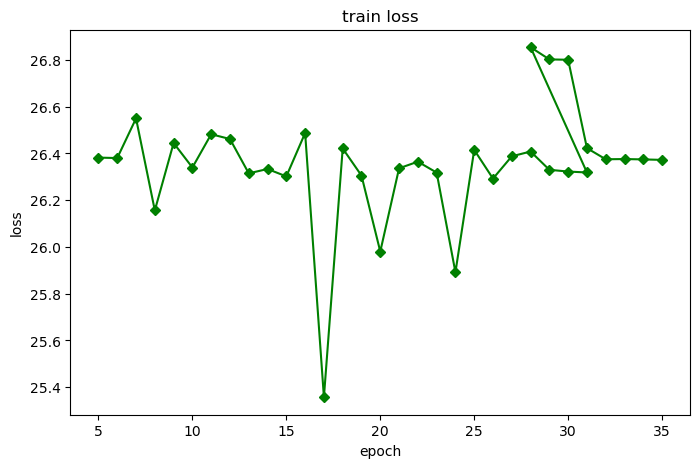

In [46]:

# 绘制loss曲线
def draw_loss_cur(logfP):
    with open(logfP, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    data_l = []
    for line in lines:
        if line[0] != '<':
            continue
        epoch, _ = line.split(',')
        epoch = int(epoch[1:].strip())
        loss = _.split('=')[1].split('. time use')[0]
        loss = float(loss.strip())
        data_l.append([epoch, loss, 1])
    new_l = []
    last = 100000
    for item in data_l:
        if item[0] == last: # 和上一个相同，则累加
            new_l[-1][1] += item[1]
            new_l[-1][2] += item[2]
        else:
            new_l.append(item)
            last = item[0]
    
    x_epoch = [item[0] for item in new_l]
    y_loss = [item[1]/item[2] for item in new_l]
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 5))
    print(x_epoch)
    print(y_loss)
    plt.plot(x_epoch, y_loss, c="g", marker='D', markersize=5)
 
    #绘制坐标轴标签
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("train loss")


draw_loss_cur('meaning_train.log')

In [47]:
max([1, 3, 5])

5